In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

from sklearn import linear_model

warnings.filterwarnings('ignore')

capture_site = pd.read_csv('data/CaptureSite_category.csv')

# Test Dataset formating

In [21]:
test_df = pd.read_csv('data/test_df.csv')

# Train Dataset Formating

In [22]:
train_df = pd.read_csv('data/train.csv')

In [23]:
train_df.head()

,Unnamed: 0,researcher,capture_site,fisher,species,ccl_cm,ccw_cm,weight_kg,year_caught,week_caught
0,0,25,0,1072,6,64.70,62.60,31.490,2000,51
1,1,6,0,520,6,35.85,31.35,4.852,2001,43
2,2,6,0,1669,5,51.80,49.20,16.776,2001,44
3,3,32,0,1798,6,60.50,59.00,29.614,2002,11
4,4,25,0,1918,5,34.70,33.00,5.060,2002,32


In [24]:
import re

# Defining function to Standartising column names 
def standardize_column_names(col):
    # Replace spaces with underscores
    col = col.replace(' ', '_')
    # Insert underscore before each uppercase letter preceded by a lowercase letter or followed by a lowercase letter
    col = re.sub(r'(?<=[a-z])(?=[A-Z])', '_', col)
    col = re.sub(r'(?<=[A-Z])(?=[A-Z][a-z])', '_', col)
    # Convert to lower case
    col = col.lower()
    # Ensure single underscores only (in case of consecutive underscores from initial spaces)
    col = re.sub(r'_+', '_', col)
    return col


In [25]:
# Applying function to df
train_df.columns = [standardize_column_names(col) for col in train_df.columns]

# Printing the updated column names to verify the changes
print(train_df.columns)

Index(['unnamed:_0', 'researcher', 'capture_site', 'fisher', 'species',
       'ccl_cm', 'ccw_cm', 'weight_kg', 'year_caught', 'week_caught'],
      dtype='object')


In [26]:
# Define the function to extract the number
def extract_number_split(s):
    return int(s.split('_')[-1])

# Define a function to apply the extraction to multiple columns
def apply_extraction(df, columns):
    for column in columns:
        df[column] = df[column].apply(extract_number_split)
    return df

In [27]:
columns_to_extract_train = ['fisher', 'researcher', 'capture_site', 'species']
train_df = apply_extraction(train_df, columns_to_extract_train)

AttributeError: 'int' object has no attribute 'split'

In [ ]:
columns_to_drop = ['rescue_id', 'turtle_characteristics', 'tag_1', 'tag_2', 'lost_tags', 't_number', 'sex',
                   'capture_method', 'release_site', 'landing_site', 'status', 'foraging_ground', 'date_time_release']

train_df = train_df.drop(columns=columns_to_drop)

In [ ]:
def convert_and_split_datetime(df, columns):
    """
    Convert specified datetime columns to timestamp and split into year and week columns
    with new names based on the original column names.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the columns.
    columns (list): List of column names to convert and split.
    
    Returns:
    pd.DataFrame: The DataFrame with new year and week columns.
    """
    for column in columns:
        # Convert the column to datetime
        df[column] = pd.to_datetime(df[column], errors='coerce')

        # Extract the base name without 'date_time_' prefix
        base_name = column.replace('date_time_', '')

        # Create new columns for year and week with the desired names
        df[f'year_{base_name}'] = df[column].dt.year
        df[f'week_{base_name}'] = df[column].dt.isocalendar().week

        # Drop the original datetime column if desired
        df.drop(columns=[column], inplace=True)

    return df

In [ ]:
# Apply function to train_df
columns_to_convert = ['date_time_caught']
train_df = convert_and_split_datetime(train_df, columns_to_convert)

train_df.head()

KeyError: 'date_time_caught'

## Imputing Missing Data in Weight

In [ ]:
from sklearn.impute import KNNImputer
def imput_missing_weight_values(df, n = 5):
    knn_df = df[['ccl_cm', 'ccw_cm', 'weight_kg']]
    imputer = KNNImputer(n_neighbors=n)
    imputer.set_output(transform='pandas')

    return imputer.fit_transform(knn_df)

In [ ]:
imputed_df = imput_missing_weight_values(train_df)
train_df['ccl_cm'] = imputed_df['ccl_cm']
train_df['ccw_cm'] = imputed_df['ccw_cm']
train_df['weight_kg'] = imputed_df['weight_kg']

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18062 entries, 0 to 18061
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   researcher    18062 non-null  int64  
 1   capture_site  18062 non-null  int64  
 2   fisher        18062 non-null  int64  
 3   species       18062 non-null  int64  
 4   ccl_cm        18062 non-null  float64
 5   ccw_cm        18062 non-null  float64
 6   weight_kg     18062 non-null  float64
 7   year_caught   18062 non-null  int32  
 8   week_caught   18062 non-null  UInt32 
dtypes: UInt32(1), float64(3), int32(1), int64(4)
memory usage: 1.1 MB


In [ ]:
train_df.to_csv('data/train.csv')

In [ ]:
train_df = pd.read_csv('data/train.csv')

# Baseline Model

In [ ]:
baseline_df = train_df.groupby(['year_caught', 'capture_site', 'week_caught']).size().reset_index(name='turtles_rescued')
baseline_df

,year_caught,capture_site,week_caught,turtles_rescued
0,1998,11,28,1
1,1998,11,32,1
2,1998,11,39,2
3,1998,11,43,1
4,1998,11,45,1
...,...,...,...,...
7952,2018,27,36,1
7953,2018,27,38,1
7954,2018,27,45,1
7955,2018,28,44,1


In [ ]:
baseline_df = baseline_df[~baseline_df['year_caught'].between(1988, 2006)].reset_index(drop=True)
baseline_df

,year_caught,capture_site,week_caught,turtles_rescued
0,2007,2,2,1
1,2007,2,3,2
2,2007,2,4,1
3,2007,2,5,1
4,2007,2,7,1
...,...,...,...,...
6461,2018,27,36,1
6462,2018,27,38,1
6463,2018,27,45,1
6464,2018,28,44,1


In [ ]:
baseline_df.drop(['year_caught'], axis=1, inplace=True)

In [ ]:
baseline_test = test_df.copy()

In [ ]:
class BaselinePredictor:
    def __init__(self, df):
        self.df = df

    def predict_turtles_rescued_all(self):
        # Initialize an empty list to store dataframes
        dfs = []

        # Get unique capture sites and weeks in the baseline_df
        capture_site_all = self.df['capture_site'].unique()
        weeks_in_year = self.df['week_caught'].unique()

        # Iterate over each capture site and week to calculate the mean turtles_rescued
        for capture_site in capture_site_all:
            for week in weeks_in_year:
                # Calculate mean turtles_rescued for the current capture site and week
                mean_turtles_rescued = self.df[(self.df['capture_site'] == capture_site) & (self.df['week_caught'] == week)]['turtles_rescued'].mean()

                # Append a dataframe to the list
                dfs.append(pd.DataFrame({'capture_site': [capture_site], 'week_caught': [week], 'turtles_rescued': [mean_turtles_rescued]}))

        # Concatenate all dataframes in the list
        predict_df = pd.concat(dfs, ignore_index=True)

        return predict_df

In [ ]:
# Initialize the predictor with the baseline_df
predictor = BaselinePredictor(baseline_df)

# Predict the baseline values
predict_baseline = predictor.predict_turtles_rescued_all()

# Print the predicted baseline DataFrame
print(predict_baseline)

      capture_site  week_caught  turtles_rescued
0                2            2         1.666667
1                2            3         1.333333
2                2            4         1.000000
3                2            5         1.500000
4                2            7         1.000000
...            ...          ...              ...
1532            17           37         2.333333
1533            17           39         1.000000
1534            17           33         1.250000
1535            17           20         1.000000
1536            17           53         1.000000

[1537 rows x 3 columns]


In [ ]:
from sklearn.metrics import mean_absolute_error

# Ensure both DataFrames have the same number of rows
num_rows_baseline_test = baseline_test.shape[0]

# Randomly sample rows from predict_baseline to match the number of rows in sample_sub
predict_baseline_trimmed = predict_baseline.sample(n=num_rows_baseline_test, random_state=42).reset_index(drop=True)

# Ensure the indices match
baseline_test = baseline_test.reset_index(drop=True)

# Combine both DataFrames to ensure we drop NaNs in corresponding rows
combined_df = pd.concat([baseline_test['turtles_rescued'], predict_baseline_trimmed['turtles_rescued']], axis=1, keys=['true', 'pred'])

# Drop rows with NaN values in either column
combined_df = combined_df.dropna()

# Separate the true and predicted values
y_true = combined_df['true']
y_pred = combined_df['pred']

# Calculate MAE
mae_baseline = mean_absolute_error(y_true, y_pred)
print(mae_baseline)


3.2108299243509903


## Contextualising MAE

In [ ]:
print(baseline_test.turtles_rescued.min())
print(baseline_test.turtles_rescued.max())

0
9


In [ ]:
target_min = 1
target_max = 9
target_range = target_max - target_min
acceptable_mae = target_range * 0.1  # Example threshold of 10% of the range
print(f"Acceptable MAE: {acceptable_mae}")

Acceptable MAE: 0.8


## RMSE Baseline

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Summary statistics
print(sample_sub['turtles_rescued'].describe())

# Baseline RMSE
mean_turtles_rescued = baseline_test['turtles_rescued'].mean()
baseline_predictions = [mean_turtles_rescued] * len(sample_sub)
baseline_mse = mean_squared_error(baseline_test['turtles_rescued'], baseline_predictions)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline RMSE: {baseline_rmse}")

# Coefficient of Variation of RMSE
cv_rmse = (rmse / mean_turtles_rescued) * 100
print(f"Coefficient of Variation of RMSE: {cv_rmse:.2f}%")

# Standard Deviation of Turtles Rescued
std_turtles_rescued = baseline_test['turtles_rescued'].std()
print(f"Standard Deviation of Turtles Rescued: {std_turtles_rescued}")
print(f"RMSE as a proportion of Standard Deviation: {rmse / std_turtles_rescued}")


Root Mean Squared Error: 3.9440045387035063


NameError: name 'sample_sub' is not defined

## Benchmarking against baseline

In [ ]:
# Calculate the MAE for the baseline model
baseline_mae = mean_absolute_error(sample_sub['turtles_rescued'], baseline_predictions)
print(f"Baseline MAE: {baseline_mae}")

# Compare baseline MAE with your model's MAE
if mae_baseline < baseline_mae:
    print("Your model is performing better than the baseline.")
else:
    print("Your model is not performing better than the baseline.")


Baseline MAE: 2.519082703589784
Your model is not performing better than the baseline.


## Interactive version

In [ ]:
def predict_turtles_rescued(capture_site, week):
    predict_df = baseline_df[(baseline_df['capture_site'] == 5) & (baseline_df['week_caught'] == 5)]
    turtle_rescued = predict_df['turtles_rescued'].mean()
    return turtle_rescued

In [ ]:
week = input(f'Enter a week number for which you would like to predict (from 1 to {len(baseline_df.week_caught.unique())}):')
capture_site = input(f'Enter a capture site number (from 1 to 29):')
print(f'Predicted Turtles Rescued for {capture_site} and {week}: {predict_turtles_rescued(capture_site, week)}')

# Enseble Model Staking

## Pipeline building

In [45]:
# machine-learning stack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PolynomialFeatures,
    FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
train_df


,unnamed:_0,researcher,capture_site,fisher,species,ccl_cm,ccw_cm,weight_kg,year_caught,week_caught
0,0,25,0,1072,6,64.70,62.60,31.490,2000,51
1,1,6,0,520,6,35.85,31.35,4.852,2001,43
2,2,6,0,1669,5,51.80,49.20,16.776,2001,44
3,3,32,0,1798,6,60.50,59.00,29.614,2002,11
4,4,25,0,1918,5,34.70,33.00,5.060,2002,32
...,...,...,...,...,...,...,...,...,...,...
18057,18057,30,9,569,5,57.13,50.57,21.090,2018,51
18058,18058,30,9,125,6,42.07,38.37,9.020,2018,51
18059,18059,30,9,1343,5,57.20,52.30,18.744,2018,52
18060,18060,30,9,1551,5,51.90,48.50,16.612,2018,52


## Predicting what turtles are caught by week

In [103]:
# loading data for model
week_model_df = train_df.copy()
week_model_df = train_df.loc[:, ~train_df.columns.str.contains('unnamed:_0')]

In [104]:
# 30% examples in test data
train_week, test_week = train_test_split(week_model_df, test_size = 0.3, random_state=1)

In [114]:
# Split into features and target
features = week_model_df.drop(['species', 'weight_kg'], axis=1)
target_species = week_model_df['species']
target_weight = week_model_df['weight_kg']
y = test_week.copy()

In [115]:
x = train_week.copy()

In [116]:
x

,researcher,capture_site,fisher,species,ccl_cm,ccw_cm,weight_kg,year_caught,week_caught
4586,20,15,1473,6,50.00,48.3,15.590,2016,5
6898,20,19,1448,6,44.37,41.2,10.480,2018,48
17127,20,9,1230,6,41.10,38.1,7.400,2015,6
5417,30,16,1478,5,38.60,37.7,7.386,2005,48
17261,20,9,996,6,28.90,28.5,3.180,2015,34
...,...,...,...,...,...,...,...,...,...
10955,30,25,1478,5,86.50,76.1,78.470,2005,13
17289,30,9,1415,6,46.00,41.5,11.700,2015,43
5192,20,15,1343,6,32.30,30.0,3.500,2018,44
12172,20,25,1464,5,37.30,37.1,6.500,2011,42


In [117]:
# Train-test split
X_train, X_test, y_train_species, y_test_species, y_train_weight, y_test_weight = train_test_split(
    features, target_species, target_weight, test_size=0.3, random_state=1)

In [118]:
# Train the RandomForestClassifier for species prediction
rf_species = RandomForestClassifier(n_estimators=100, random_state=1)
rf_species.fit(X_train, y_train_species)

RandomForestClassifier(random_state=1)

In [119]:
# Train the RandomForestRegressor for weight prediction
rf_weight = RandomForestRegressor(n_estimators=100, random_state=1)
rf_weight.fit(X_train, y_train_weight)

RandomForestRegressor(random_state=1)

In [120]:
# Predictions
species_predictions = rf_species.predict(X_test)
weight_predictions = rf_weight.predict(X_test)

Classification Report for Species Prediction:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.83      0.59      0.69        17
           5       0.90      0.92      0.91      3281
           6       0.87      0.85      0.86      2110
           7       0.00      0.00      0.00         6

    accuracy                           0.89      5419
   macro avg       0.37      0.34      0.35      5419
weighted avg       0.89      0.89      0.89      5419

Mean Squared Error for Weight Prediction: 5.26388102338744
R-squared for Weight Prediction: 0.9605364790930746


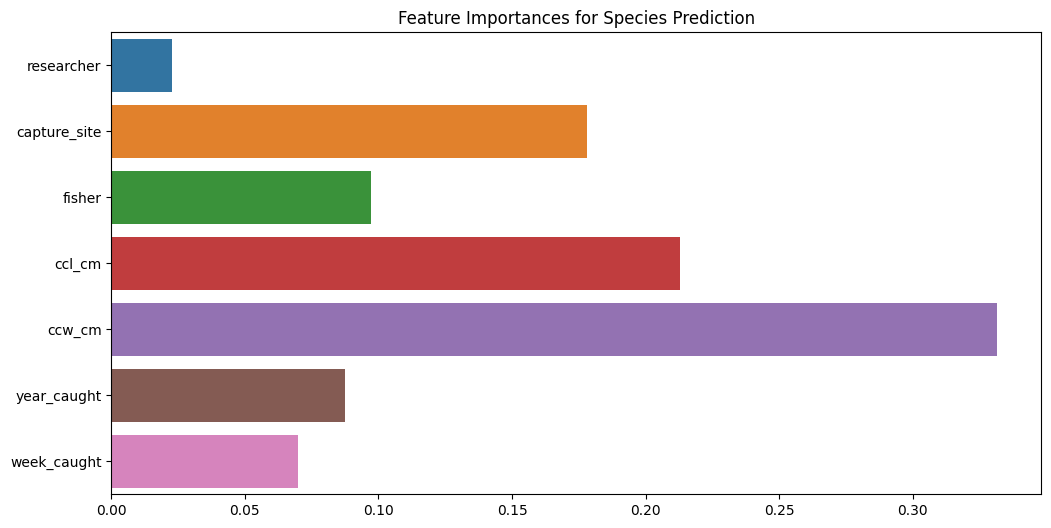

In [121]:
# Evaluation for species prediction
print("Classification Report for Species Prediction:\n", classification_report(y_test_species, species_predictions))

# Evaluation for weight prediction
mse = mean_squared_error(y_test_weight, weight_predictions)
r2 = r2_score(y_test_weight, weight_predictions)
print(f"Mean Squared Error for Weight Prediction: {mse}")
print(f"R-squared for Weight Prediction: {r2}")

# Plotting feature importances for species prediction
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_species.feature_importances_, y=features.columns)
plt.title('Feature Importances for Species Prediction')
plt.show()


## Predicting what turtles are caught by capture_site

In [95]:
# Define features and target
features = week_model_df.drop(['week_caught'], axis=1)
target = week_model_df['week_caught']

In [96]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1)


In [97]:
# Train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [98]:
# Predictions
predictions = rf.predict(X_test)

In [99]:
from sklearn.metrics import classification_report, confusion_matrix

In [100]:
# Evaluation
print("Classification Report:\n", classification_report(y_test, predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, predictions))

Classification Report:
               precision    recall  f1-score   support

           1       0.11      0.13      0.12       106
           2       0.14      0.12      0.12       113
           3       0.10      0.09      0.10        98
           4       0.07      0.08      0.08        86
           5       0.05      0.05      0.05       116
           6       0.11      0.12      0.12        81
           7       0.10      0.12      0.11        98
           8       0.10      0.09      0.09       104
           9       0.08      0.09      0.09        98
          10       0.09      0.10      0.10        91
          11       0.04      0.04      0.04       100
          12       0.07      0.09      0.08        81
          13       0.05      0.04      0.05        97
          14       0.08      0.09      0.08        76
          15       0.10      0.07      0.08        94
          16       0.09      0.05      0.06       100
          17       0.08      0.10      0.09        86
   

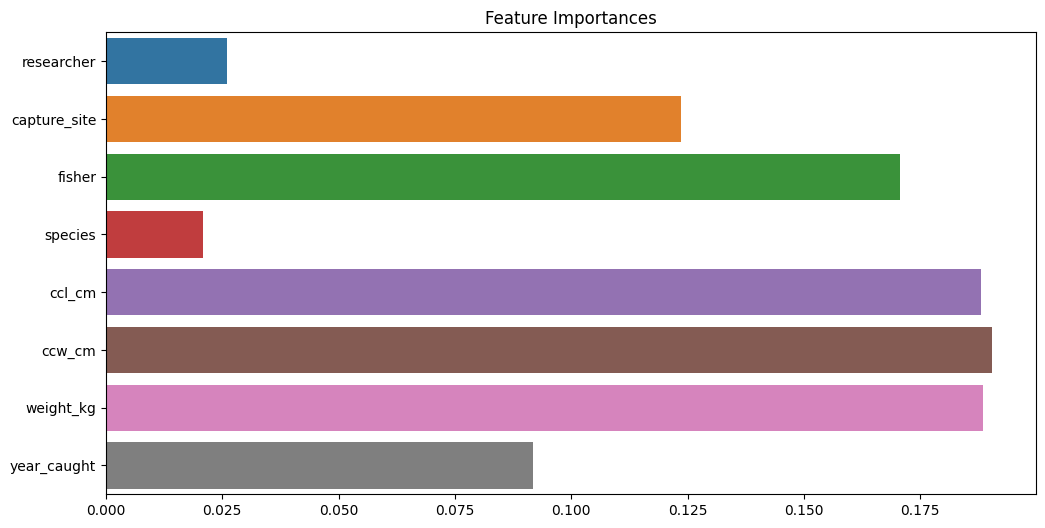

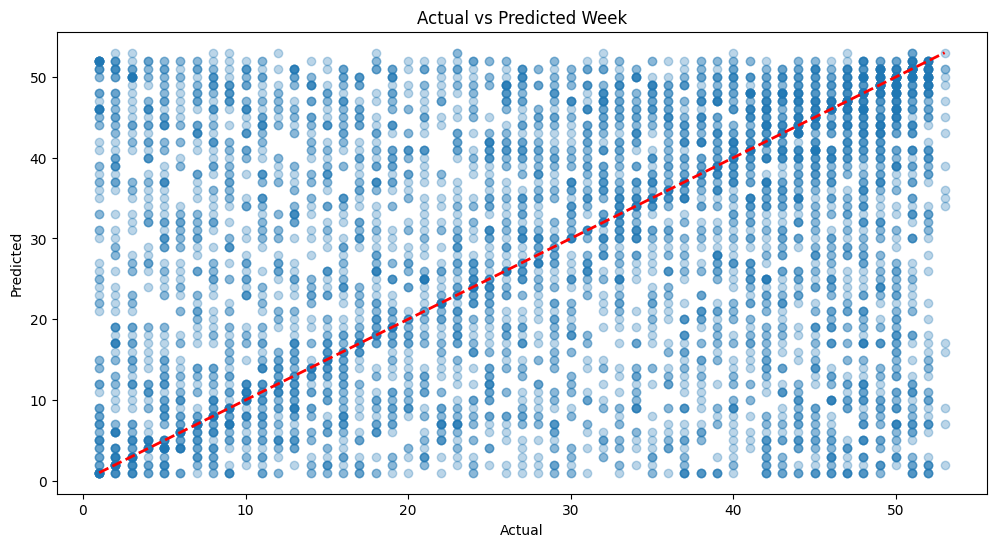

In [101]:
# Plotting feature importances
plt.figure(figsize=(12, 6))
sns.barplot(x=rf.feature_importances_, y=features.columns)
plt.title('Feature Importances')
plt.show()

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, predictions, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Week')
plt.show()